In [174]:
#numpy est une bibliothèque destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
import numpy as np
#open3d est une bibliothèque open-source qui prend en charge le développement rapide de logiciels traitant des données 3D.
import open3d as o3d
from numpy.linalg import eig
import plotly.express as px
import plotly.graph_objects as go 
from sklearn.decomposition import PCA 
import pandas as pd
#ce module est pour la normalisation des données
from sklearn.preprocessing import StandardScaler
import glob
import os
import trimesh
import pandas as pd
from pyntcloud import PyntCloud 

In [175]:
#Cette fonction exporte le nuage des points generée en fichier .ply 
def use_pyntcloud(pts, write_text):
    # ref: https://pyntcloud.readthedocs.io/en/latest/io.html
    # the doc is scarce and not complete

    n = len(pts)

    # The points must be written as a dataframe,
    # ref: https://stackoverflow.com/q/70304087/6064933
    data = {'x': pts[:, 0],
            'y': pts[:, 1],
            'z': pts[:, 2],
            'red': np.random.rand(n),
            'blue': np.random.rand(n),
            'green': np.random.rand(n)
            }

    # build a cloud
    cloud = PyntCloud(pd.DataFrame(data))

    # the argument for writing ply file can be found in
    # https://github.com/daavoo/pyntcloud/blob/7dcf5441c3b9cec5bbbfb0c71be32728d74666fe/pyntcloud/io/ply.py#L173
    #Vous pouvez egalement changer l'emplacement des resultat selon le type d'objets [DeskGen, BathtubGen ,...........]
    name = 'Output/ChairGen/'+write_text+'.ply'
    cloud.to_file(name, as_text=write_text)

    # read file
    cloud = PyntCloud.from_file(name)
    # print(cloud)

In [176]:
#Fonction qui prend le chemin d'objet 3D [.ply] et il affiche une figure de representation des objets en maillage triangulaire  
def visualize_mesh(path_obj):
    mesh = o3d.io.read_triangle_mesh(path_obj)
    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:,0],
                y=vertices[:,1],
                z=vertices[:,2],
                i=triangles[:,0],
                j=triangles[:,1],
                k=triangles[:,2],
                facecolor=colors,
                opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
#Fonction qui prend le tableau de nuage de points d'objet 3D [.ply] et il affiche une figure de representation des objets en nuage de points 
def visualize_cloud(points):
    fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color='black')
        )
        ],
        layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
        )
        )
    fig.show()
#visualisation de maillage triangulaire a partir d'un nuage de points
def visualize_mesh_from_point_cloud(p):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p)
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd,9)
    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:,0],
                y=vertices[:,1],
                z=vertices[:,2],
                i=triangles[:,0],
                j=triangles[:,1],
                k=triangles[:,2],
                facecolor=colors,
                opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [177]:
points = []
num_points=2047 
k=60

In [178]:
# visualize_mesh('C:/Users/user/Downloads/New folder/3D/arch/o1.ply')

In [179]:
#Vous pouvez egalement ici de changer le path selon votre base de donnees 
files = glob.glob(os.path.join("Input/ModelNet10/chair/train/*"))
for f in files:
    points.append(trimesh.load(f).sample(num_points))  
        
points = np.asarray(points)
points.shape

(889, 2047, 3)

In [203]:
#Nombre d'objet dans la base de données
n_samples = points.shape[0]

In [204]:
visualize_cloud(points[0,:,:])

In [205]:
#Caluclant la forme moyenne de tous les objets dans la base de données
Smoy = np.zeros((num_points,3))
for i in range(n_samples):
    Smoy += points[i,:,:]

Smoy = (1/n_samples) * Smoy

In [206]:
print("Smoy shape",Smoy.shape)

Smoy shape (2047, 3)


In [207]:
#Calculant les vecteurs de deformation
Sdf = np.zeros((n_samples,num_points,3))
for i in range(n_samples):
    Sdf[i,:,:]= points[i,:,:] - Smoy

In [208]:
#Matrice de covariance 
C = np.zeros((num_points,num_points))
for i in range(n_samples):
    C += Sdf[i,:,:] @ Sdf[i,:,:].T
C = (1/n_samples)*C

In [209]:
C.shape

(2047, 2047)

In [210]:
#Calculant la matrice des vecteurs propres et le vecteur des valeurs propres
eigen_vals, eigen_vecs = np.linalg.eigh(C)
print('E-value:', eigen_vals)
print('E-vector', eigen_vecs)

E-value: [-2.83136348e-06 -2.77617781e-06 -4.41572214e-07 ...  4.15119397e+09
  8.66629103e+09  2.83906401e+10]
E-vector [[ 0.00000000e+00  1.76787412e-05  0.00000000e+00 ... -1.89199834e-02
   3.16067333e-02 -9.12949387e-04]
 [ 6.13540690e-02 -3.37289631e-03 -2.09617617e-02 ... -8.43112458e-03
  -3.05160164e-03 -2.35694675e-02]
 [-4.13877046e-01  2.57873370e-01 -8.12043528e-03 ...  6.67682521e-03
   1.74011178e-02 -2.86091571e-02]
 ...
 [ 7.86930450e-03  1.47213599e-04  1.12949808e-02 ... -1.06895181e-02
  -2.86292357e-02  3.03083166e-03]
 [-7.25045128e-03  1.44703559e-02 -4.32397540e-03 ...  1.19430097e-02
  -1.19294473e-02  7.84609357e-03]
 [-2.96400091e-04  2.28473301e-02 -2.09878454e-03 ... -2.14928192e-02
   2.33256376e-02 -1.47104168e-02]]


In [211]:
#Déterminer la variance expliquée
threshold = 0.95
egnvalues = eigen_vals
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

Nombre de composantes expliquant 0.95% la variance: 3




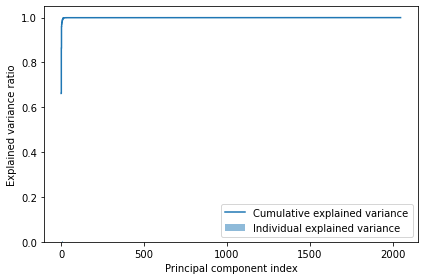

In [212]:
#Tracer la variance expliquée par rapport à la variance expliquée cumulative
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
threshold = 0.95
k = np.argmax( cum_sum_exp > threshold) + 1
print(f"Nombre de composantes expliquant {threshold}% la variance: " + str(k))
print("\n")
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [191]:
#Obtenir les composants principaux [p1, p2, p3,....,pk] 
sort = eigen_vals[::-1].argsort() 
eigen_vals[::-1].sort() 
eigen_vecs = eigen_vecs[:, sort]
eigenmesh =  np.column_stack((eigen_vecs[:,0:k]))
#size kx N
print("shape of eigen mesh",eigenmesh.shape) 

shape of eigen mesh (4, 2047)


In [192]:
#Calucant le weight pour chaque objet
weights = np.zeros((n_samples,k,3))
for i in range(n_samples):
    weights[i,:,:] =  eigenmesh @ (points[i,:,:] - points[0,:,:].mean())

In [193]:
weights.shape

(534, 4, 3)

In [195]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[7,:,:])
o3d.visualization.draw_geometries([pcd])  

In [196]:
#Tester le code
newscan = eigenmesh.T @ weights[70] + Smoy
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(newscan)
o3d.visualization.draw_geometries([pcd])  

In [215]:
#exporter la data generée sous format .ply
use_pyntcloud(newscan,"test")

In [198]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(newscan)
o3d.visualization.draw_geometries([pcd]) 

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
#visualisation de la différence entre objet orginal et l'objet augmente
def diff_points_cloud(k):
    visualize_cloud(newdata[k,:,:])
    print("========================================")
    visualize_cloud(points[k,:,:])

In [ ]:
#Reconstructed data 
newdata = np.zeros((n_samples,num_points,3))
for i in range(n_samples):
    newdata[i,:,:] =  eigenmesh.T @ weights[i,:,:] + Smoy


In [ ]:
#Extract Data 
'''Chair '''
    
for i in range(len(newdata)):
    name = "hair_"+str(i)+"_gen"
    use_pyntcloud(newdata[i], name)
    
'''Bathtub '''
# for i in range(len(newdata)):
#     filename = "gen_bath"+str(i)
#     use_pyntcloud(newdata[i],filename)

In [214]:
diff_points_cloud(70)